In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt

In [3]:
from foolbox import PyTorchModel, accuracy
import foolbox.attacks as fa
import foolbox as fb

import numpy as np
import xarray as xr

In [4]:
import torch

import sys
sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research/')
import Finite_Gaussian_Network_lib as fgnl
import Finite_Gaussian_Network_lib.fgn_helper_lib as fgnh

In [5]:
# check gpus
!gpustat

countdown               Mon Jul 13 16:41:37 2020  418.87.01
[0] GeForce RTX 2080 Ti | 54'C,   0 % |   786 / 10989 MB | felix(775M)
[1] GeForce RTX 2080 Ti | 62'C,   6 % |  6191 / 10988 MB | felix(5235M) felix(775M) root(169M)


In [6]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
use_cuda = False
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
print("Using device:", device)

# manualy set cuda device
torch.cuda.set_device(0)

CUDA Available:  True
Using device: cpu


In [7]:
# define the attacks 
attacks = [
        fa.FGSM(),
        fa.LinfPGD(),
        fa.LinfBasicIterativeAttack(),
        fa.LinfAdditiveUniformNoiseAttack(),
        fa.LinfDeepFoolAttack(),
    ]

# for now restrict to FGSM
# attacks = [attacks[0]]
FGSM_attack = attacks[0]

# params to explore
epsilons = [
    0.0,
    0.0005,
    0.001,
    0.0015,
    0.002,
    0.003,
    0.005,
    0.01,
    0.02,
    0.03,
    0.1,
    0.3,
    0.5,
    1.0,
]
print('epsilons')
print(epsilons)

epsilons
[0.0, 0.0005, 0.001, 0.0015, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.1, 0.3, 0.5, 1.0]


In [8]:
# get data 
(mnist_train_loader, mnist_val_loader, mnist_test_loader) = fgnh.mnist_dataloaders(batch_size=10000, 
                                                                                   batch_size_for_val=10000)

images, labels = mnist_val_loader.dataset.tensors
images = images.to(device)
labels = labels.to(device)

In [9]:
type(images), images.shape

(torch.Tensor, torch.Size([10000, 28, 28]))

In [10]:
type(labels), labels.shape

(torch.Tensor, torch.Size([10000]))

In [11]:
# minimum/maximum pixel value post normalization, from train dataset
min_pix = -0.4242129623889923095703125
max_pix =  2.8214867115020751953125000
# mean and std of train set
train_mean = -0.0000061691193877777550369501113891601562500000000
train_std = 0.999999344348907470703125000000

# pre-processing for fmodels
preprocessing = dict(mean=train_mean, std=train_std)

In [12]:
# sample FGN model 
fgn_model_path = "../Experiments/sample_models/sample_FGN_full.pth"
fgn_model = torch.load(fgn_model_path)

# apply same as above
fgn_model.eval()

fgn_f_model = PyTorchModel(fgn_model, bounds=(min_pix, max_pix), preprocessing=preprocessing)

In [16]:
#make sure everything is on the same device
fgn_model.to(device)

Feedforward_FGN_net(
  (hidden_layers): ModuleList(
    (0): Dropout(p=0.2, inplace=False)
    (1): FGN_layer()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): FGN_layer()
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.2, inplace=False)
  )
  (ib): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fl): FGN_layer()
)

In [17]:
print('accuracy')
print(accuracy(fgn_f_model, images, labels))

accuracy
0.9757000207901001


In [15]:
# X-dim dataset with dims = [attack_func, epsilon, index, result]
# thats stores results of an attack with result = {'raw', 'clipped', 'success'} dict
fgn_attack_success = np.empty( (len(attacks), len(epsilons), len(images)), dtype=type({}) )
# np.array([{} for _ in range(len(attacks)*len(epsilons)*len(images))]).reshape(len(attacks), len(epsilons), len(images))
fgn_attack_success = xr.DataArray(data=fgn_attack_success, 
                                  dims=['attack', 'epsilon', 'index'],
                                  coords={'attack':[str(a) for a in attacks],
                                          'epsilon':epsilons, 
                                          'index':range(len(images))})

In [16]:
type(fgn_f_model), type(images), type(labels), type(epsilons)

(foolbox.models.pytorch.PyTorchModel, torch.Tensor, torch.Tensor, list)

In [17]:
# attack the fgn model
raw, clipped, adv_success = FGSM_attack(fgn_f_model, images, labels, epsilons=epsilons)

In [18]:
# print stats
print(FGSM_attack)
print('  ', 1.0 - adv_success.cpu().numpy().mean(axis=-1))

LinfFastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)
   [0.9757 0.9697 0.9497 0.9219 0.8691 0.7693 0.5968 0.2794 0.1107 0.102
 0.099  0.099  0.0963 0.0961]


In [19]:
# i want this to have (14, 10000) shape
successes = adv_success.detach().cpu().numpy()
raws = np.array([r.detach().cpu().numpy() for r in raw])
clippeds = np.array([c.detach().cpu().numpy() for c in clipped])
results = np.array([ [{'raw':r, 'clipped':c, 'success':s}
            for (r,c,s) in zip(x, y, z)
           ] 
         for x,y,z in zip(raws, clippeds, successes)
         ] )
results.shape

(14, 10000)

In [20]:
# set values for location
fgn_attack_success.loc[dict(attack=str(FGSM_attack))] = results

In [21]:
# plot an attack
ind = 99
eps=epsilons[13]
print('eps:', eps)
v = fgn_attack_success.sel(attack=str(FGSM_attack), epsilon=eps, index=ind).values.reshape(1)[0]

eps: 1.0


attack successful: False
Raw Adv


<IPython.core.display.Javascript object>


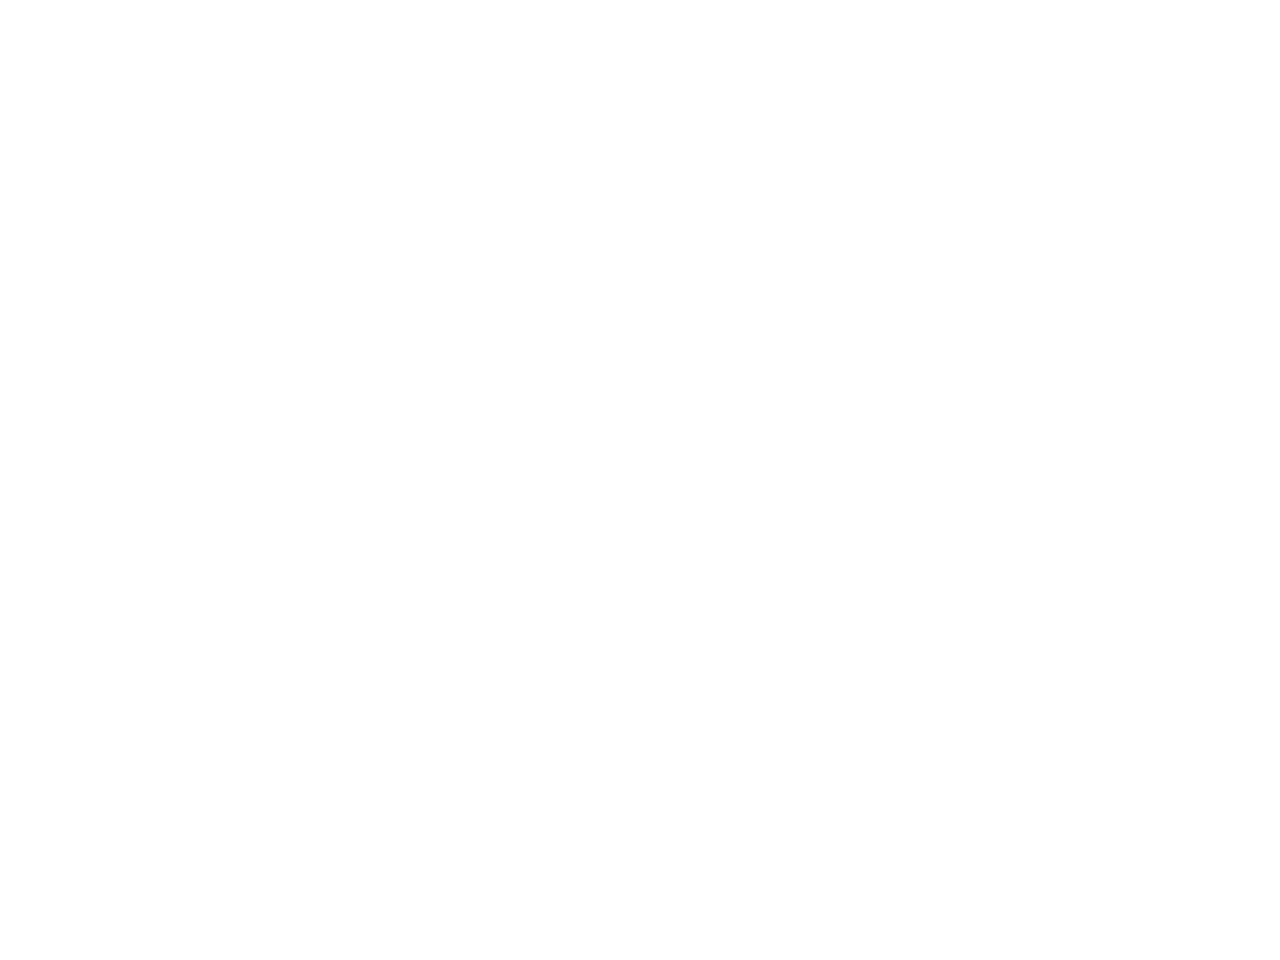

Clipped Adv


<IPython.core.display.Javascript object>


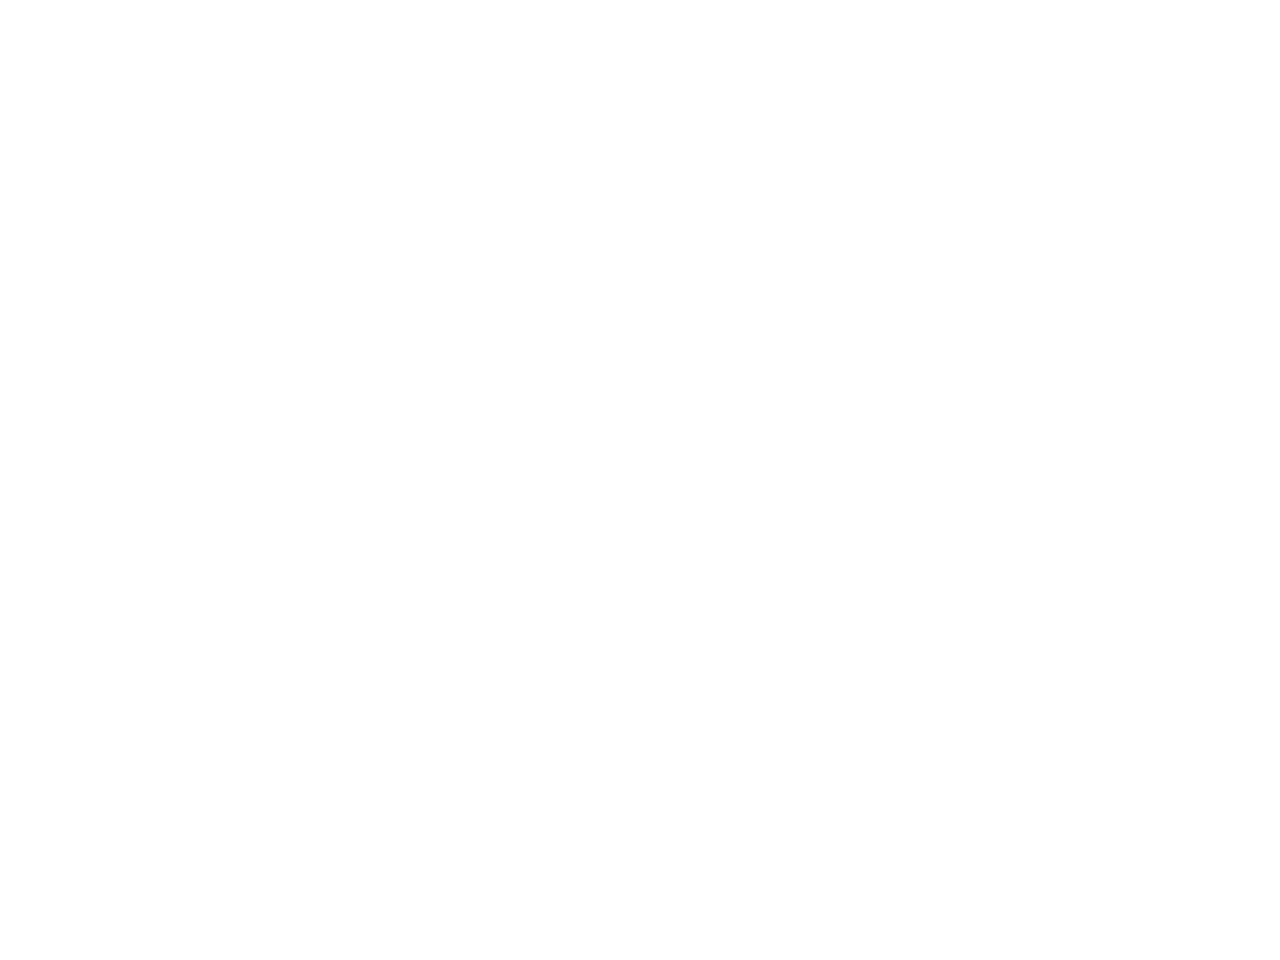

In [22]:
print('attack successful: {}'.format(v['success']))
print('Raw Adv')
plt.imshow(v['raw'], cmap=plt.cm.get_cmap('Greys'))
plt.colorbar()
plt.show()

print('Clipped Adv')
plt.imshow(v['clipped'], cmap=plt.cm.get_cmap('Greys'))
plt.colorbar()
plt.show()

In [23]:
# check pred
x = mnist_val_loader.dataset[ind][0].numpy()

original image


<IPython.core.display.Javascript object>


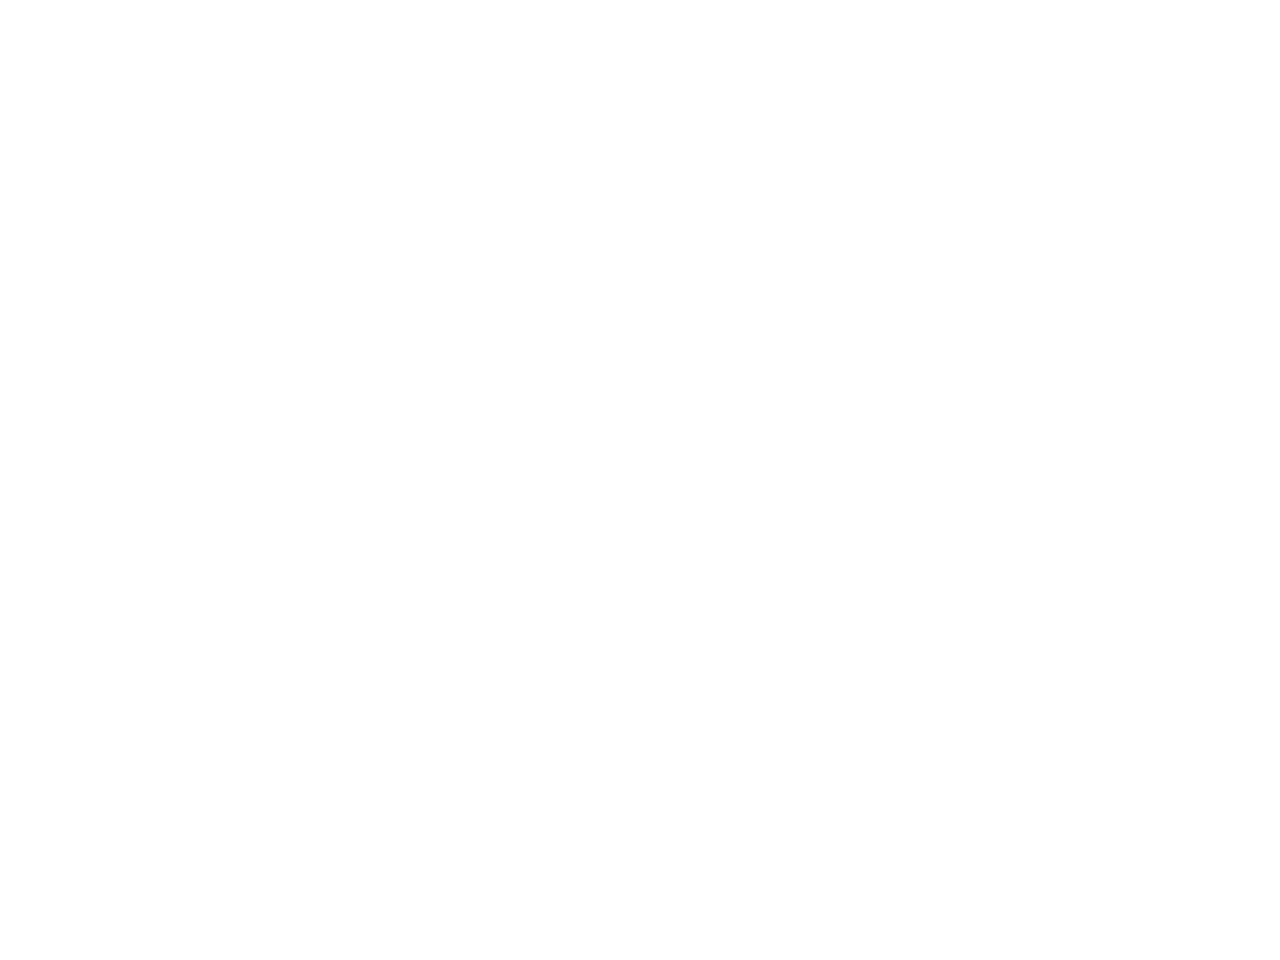

In [24]:
print('original image')
plt.imshow(x, cmap=plt.cm.get_cmap('Greys'))
plt.colorbar()
plt.show()

raw noise difference


<IPython.core.display.Javascript object>


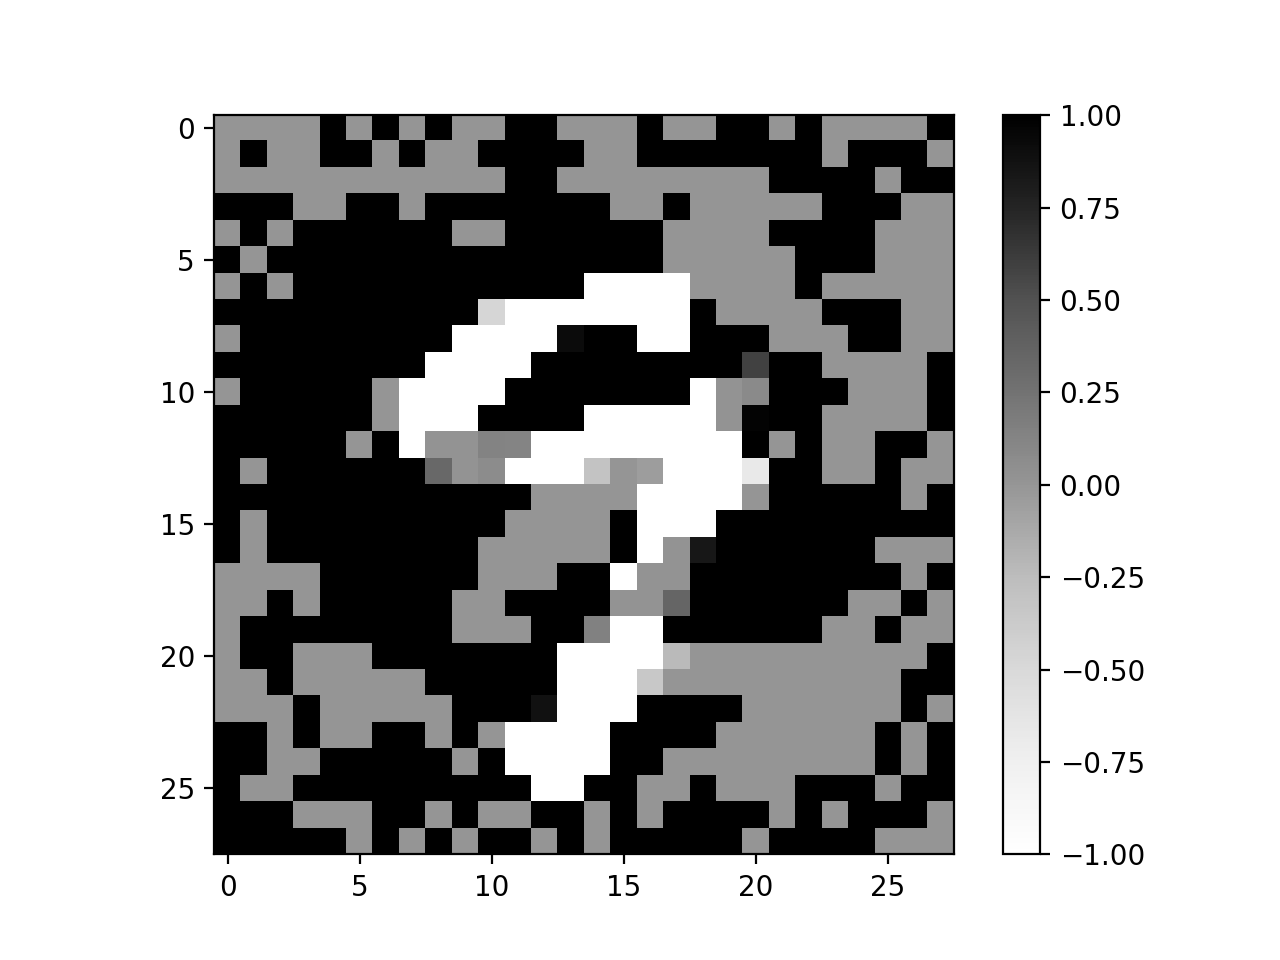

In [25]:
print('raw noise difference')
plt.imshow(v['raw']-x, cmap=plt.cm.get_cmap('Greys'))
plt.colorbar()
plt.show()

clipped noise difference


<IPython.core.display.Javascript object>


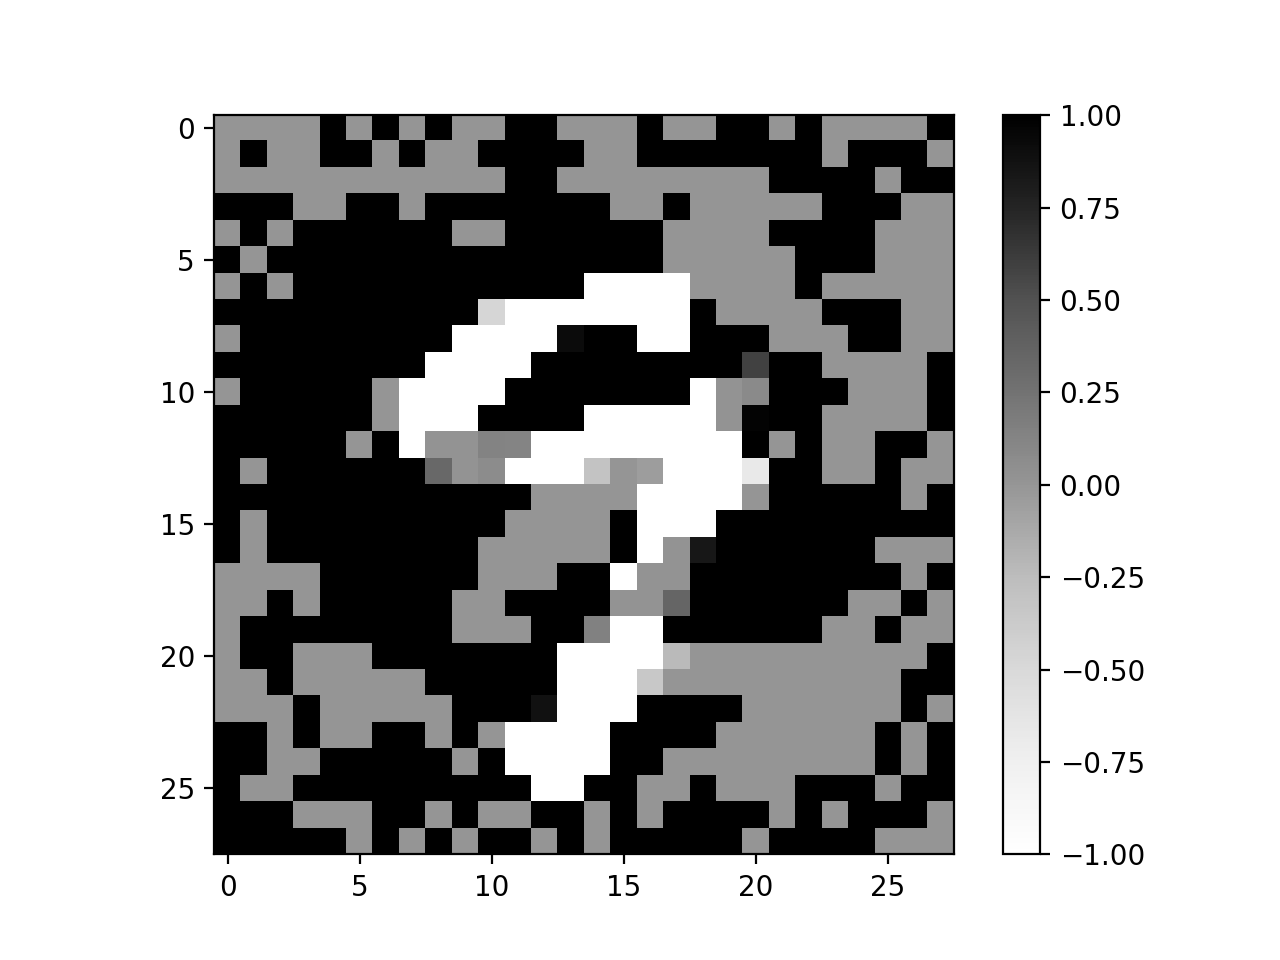

In [26]:
print('clipped noise difference')
plt.imshow(v['clipped']-x,  vmin=-1, vmax=1, cmap=plt.cm.get_cmap('Greys'))
plt.colorbar()
plt.show()

In [27]:
(raw == clipped).all

RuntimeError: bool value of Tensor with more than one value is ambiguous

In [ ]:
# pred = fgn_model(torch.Tensor(v['raw']).to(device) )
# pred = fgn_model(torch.Tensor(v['clipped']).to(device) )
pred = fgn_model(torch.Tensor(x).to(device) )
pred = pred.cpu().detach().numpy()[0]
print(pred.round(2))
# apply softmax for probs
pred_softmax = np.exp(pred) / np.sum(np.exp(pred)) 
print(pred_softmax)
print(np.argmax(pred))

In [ ]:
# load a classic model
classic_model_path = '../Experiments/sample_models/sample_classic_full.pth'
classic_model = torch.load(classic_model_path)

# ready it for foolbox
classic_model.eval()
classic_fmodel = PyTorchModel(classic_model, bounds=(min_pix, max_pix), preprocessing=preprocessing)

In [ ]:
# make sure everything is on the same device
classic_model.to(device)

In [ ]:
# quick eval to check all is good
print('accuracy')
print(accuracy(classic_fmodel, images, labels))

In [ ]:
# attack the classic model
attack_success = np.zeros((len(attacks), len(epsilons), len(images)), dtype=np.bool)
for i, attack in enumerate([attacks[0]]):
    adv, _, success = attack(classic_fmodel, images, labels, epsilons=epsilons)
    assert success.shape == (len(epsilons), len(images))
    success_ = success.cpu().numpy()
    assert success_.dtype == np.bool
    attack_success[i] = success_
    print(attack)
    print('  ', 1.0 - success_.mean(axis=-1).round(2))

In [ ]:
plt.imshow(adv[-1][ind].detach().cpu().numpy(),  cmap=plt.cm.get_cmap('Greys'))
plt.show()

In [ ]:
res = classic_model(adv[-1][ind])
print(res)
print(np.argmax(res.detach().cpu().numpy()))
r = res.detach().cpu().numpy()
r = np.exp(r)/np.sum(np.exp(r))
print(r.round(2))

In [ ]:
# shared network parameters
hidden_layer_sizes = [64,64]
drop_p = 0.2

# fgn specific params
print("hidden layers:", hidden_layer_sizes)
# covariance type: sphere, diag or full/chol
covar_type = 'diag'
print("covariance:", covar_type)
ordinal = float(2.0)
print("ordinal for norm:", ordinal)
non_lin = True
print("non linearity:", non_lin)
free_biases=True
print("free biases:", free_biases)

print("drop prob:", drop_p)

In [ ]:
# convert the classic model
# model to convert
converted_model = fgnl.Feedforward_FGN_net(in_feats=28*28, out_feats=10, hidden_layer_sizes=hidden_layer_sizes, drop_p=drop_p,
                                         covar_type=covar_type, ordinal=ordinal, non_lin=non_lin)


fgnl.convert_classic_to_fgn(classic_model, fgn_model=converted_model)
converted_model.eval()

converted_fmodel = PyTorchModel(converted_model, bounds=(min_pix, max_pix), preprocessing=preprocessing)

In [ ]:
# make sure everything is on the same device
converted_model.to(device)

In [ ]:
# quick eval to check all is good
print('accuracy')
print(accuracy(converted_fmodel, images, labels))
print('')

In [ ]:
# attack the converted model
attack_success = np.zeros((len(attacks), len(epsilons), len(images)), dtype=np.bool)
for i, attack in enumerate(attacks):
    _, _, success = attack(converted_fmodel, images, labels, epsilons=epsilons)
    assert success.shape == (len(epsilons), len(images))
    success_ = success.cpu().numpy()
    assert success_.dtype == np.bool
    attack_success[i] = success_
    print(attack)
    print('  ', 1.0 - success_.mean(axis=-1).round(2))

In [ ]:
# train the converted model
import torch.optim as optim

optimizer = optim.Adam(filter(lambda p: p.requires_grad, converted_model.parameters()), lr=0.001)

lmbda_l2 = (4.0*0.1/len(mnist_train_loader.dataset))
lmbda_sigs = 0.1

cross_ent_loss = fgnl.def_fgn_cross_ent_loss(lmbda_l2, lmbda_sigs)

In [ ]:
# train the network for N epochs
epochs = 1
train_res = fgnh.train(converted_model, mnist_train_loader, 
                             cross_ent_loss, optimizer, epochs, save_hist=2, verbose=True, 
                             pred_func=fgnh.cross_ent_pred_accuracy, test_loader=mnist_val_loader)

In [ ]:
# check that inv covar has gone up, sigmas down, and trace down if covar_type=='full'
fgnl.plot_sigmas_histories(train_res['histories'], covar_type=converted_model.covar_type)

In [ ]:
# attack the converted model again
attack_success = np.zeros((len(attacks), len(epsilons), len(images)), dtype=np.bool)
for i, attack in enumerate(attacks):
    _, _, success = attack(converted_fmodel, images, labels, epsilons=epsilons)
    assert success.shape == (len(epsilons), len(images))
    success_ = success.cpu().numpy()
    assert success_.dtype == np.bool
    attack_success[i] = success_
    print(attack)
    print('  ', 1.0 - success_.mean(axis=-1).round(2))

In [ ]:
# plt.plot(epsilons, robust_accuracy.numpy())

In [ ]:
# look at he examples
